# Demo for Native Function Calling Capability of Bedrock Claude

* Codes borrowed from [Zeek Granston's Blog](https://medium.com/@zeek.granston/function-calling-with-anthropic-claude-and-amazon-bedrock-c6eda7358b0f)  
* A little bit straightforward comparing with Bedrock Agent

In [1]:
!pip install defusedxml requests boto3 awscli -qU

In [ ]:
import os

images_folder = "./claude_functioncalls"
os.makedirs(images_folder, exist_ok=True)
%cd claude_functioncalls

* Function for generating images, you need to replace "server_address" and "prompt_text" with your own

In [ ]:
%%writefile ./tools.py
import os
import json
import random
from urllib import request, parse

def image_generator(final_prompt: str):
    server_address = "ec2-54-242-8-85.compute-1.amazonaws.com:8080"
    prompt_text = """
    {
      "4": {
        "inputs": {
          "ckpt_name": "sd_xl_base_1.0.safetensors"
        },
        "class_type": "CheckpointLoaderSimple",
        "_meta": {
          "title": "Load Checkpoint - BASE"
        }
      },
      "5": {
        "inputs": {
          "width": 1024,
          "height": 1024,
          "batch_size": 1
        },
        "class_type": "EmptyLatentImage",
        "_meta": {
          "title": "Empty Latent Image"
        }
      },
      "6": {
        "inputs": {
          "text": "evening sunset scenery blue sky nature, glass bottle with a galaxy in it",
          "clip": [
            "4",
            1
          ]
        },
        "class_type": "CLIPTextEncode",
        "_meta": {
          "title": "CLIP Text Encode (Prompt)"
        }
      },
      "7": {
        "inputs": {
          "text": "text, watermark",
          "clip": [
            "4",
            1
          ]
        },
        "class_type": "CLIPTextEncode",
        "_meta": {
          "title": "CLIP Text Encode (Prompt)"
        }
      },
      "10": {
        "inputs": {
          "add_noise": "enable",
          "noise_seed": 451308300658698,
          "steps": 20,
          "cfg": 8,
          "sampler_name": "euler",
          "scheduler": "normal",
          "start_at_step": 0,
          "end_at_step": 16,
          "return_with_leftover_noise": "enable",
          "model": [
            "4",
            0
          ],
          "positive": [
            "6",
            0
          ],
          "negative": [
            "7",
            0
          ],
          "latent_image": [
            "5",
            0
          ]
        },
        "class_type": "KSamplerAdvanced",
        "_meta": {
          "title": "KSampler (Advanced) - BASE"
        }
      },
      "11": {
        "inputs": {
          "add_noise": "disable",
          "noise_seed": 0,
          "steps": 20,
          "cfg": 8,
          "sampler_name": "euler",
          "scheduler": "normal",
          "start_at_step": 16,
          "end_at_step": 10000,
          "return_with_leftover_noise": "disable",
          "model": [
            "12",
            0
          ],
          "positive": [
            "15",
            0
          ],
          "negative": [
            "16",
            0
          ],
          "latent_image": [
            "10",
            0
          ]
        },
        "class_type": "KSamplerAdvanced",
        "_meta": {
          "title": "KSampler (Advanced) - REFINER"
        }
      },
      "12": {
        "inputs": {
          "ckpt_name": "sd_xl_refiner_1.0.safetensors"
        },
        "class_type": "CheckpointLoaderSimple",
        "_meta": {
          "title": "Load Checkpoint - REFINER"
        }
      },
      "15": {
        "inputs": {
          "text": "evening sunset scenery blue sky nature, glass bottle with a galaxy in it",
          "clip": [
            "12",
            1
          ]
        },
        "class_type": "CLIPTextEncode",
        "_meta": {
          "title": "CLIP Text Encode (Prompt)"
        }
      },
      "16": {
        "inputs": {
          "text": "text, watermark",
          "clip": [
            "12",
            1
          ]
        },
        "class_type": "CLIPTextEncode",
        "_meta": {
          "title": "CLIP Text Encode (Prompt)"
        }
      },
      "17": {
        "inputs": {
          "samples": [
            "11",
            0
          ],
          "vae": [
            "12",
            2
          ]
        },
        "class_type": "VAEDecode",
        "_meta": {
          "title": "VAE Decode"
        }
      },
      "19": {
        "inputs": {
          "filename_prefix": "ComfyUI",
          "images": [
            "17",
            0
          ]
        },
        "class_type": "SaveImage",
        "_meta": {
          "title": "Save Image"
        }
      }
    }
    """

    def queue_prompt(prompt):
        p = {"prompt": prompt}
        data = json.dumps(p).encode('utf-8')
        req =  request.Request("http://{}/prompt".format(server_address), data=data)
        # request.urlopen(req)
        return json.loads(request.urlopen(req).read())

    def get_history(prompt_id):
        while True:
            with request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
                data = json.loads(response.read())
                if data:
                    return data
            
    def get_image(filename, subfolder, folder_type):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = parse.urlencode(data)
        image_url = "http://{}/view?{}".format(server_address, url_values)
        return image_url

    prompt = json.loads(prompt_text)

    # set the text prompt for our positive and negtive CLIPTextEncode
    prompt["6"]["inputs"]["text"] = prompt["15"]["inputs"]["text"] = final_prompt
    negative_prompt = "ugly, disfigured, distorted body, bad anatomy, bad hands, text, watermark"
    prompt["7"]["inputs"]["text"] = prompt["16"]["inputs"]["text"] = negative_prompt

    #set the seed for our KSampler node
    random_integer = random.randint(1, 18446744073709551615)
    prompt["10"]["inputs"]["noise_seed"] = random_integer

    resp = queue_prompt(prompt)

    prompt_id = resp['prompt_id']
    history = get_history(prompt_id)[prompt_id]
    output_images = {}
    for node_id in history['outputs']:
        node_output = history['outputs'][node_id]
        if 'images' in node_output:
            images_output = []
            for image in node_output['images']:
                image_data = get_image(image['filename'], image['subfolder'], image['type'])
                images_output.append(image_data)
        output_images[final_prompt] = images_output
    return output_images

image_generator_description = """
<tool_description>
<tool_name>image_generator</tool_name>
<description>
Generate images for a given prompt and return prompt with images' URL. </description>
<parameters>
<parameter>
<name>final_prompt</name>
<type>string</type>
<description>The prompt for generating images</description>
</parameter> 
</parameters>
</tool_description>
"""

list_of_tools_specs = [image_generator_description]

In [4]:
import sys
from defusedxml import ElementTree
from collections import defaultdict
import os
from typing import Any
import tools
import boto3
import json
import requests
from IPython.display import display, Image

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [5]:
# Create a folder to prepare saving created images

images_folder = "./output_image"
os.makedirs(images_folder, exist_ok=True)

In [6]:
def create_prompt(tools_string, user_input):
    prompt_example = "Snow Princess, smooth soft skin, symmetrical, soft lighting, detailed face, looking into camera."
    prompt_template = f"""
You are an agent who can generate images using Stable Diffusion. Your job is to extract relevant image description from user input, then enrich and rewrite description into a prompt as much detail as possible to let Stable Diffusion understand. After that, you use one or more tools equipped for you to generate images based on the final prompt.

You may call the tools like this. Only invoke one function at a time and wait for the results before invoking another function:
<function_calls>
<invoke>
<tool_name>$TOOL_NAME</tool_name>
<parameters>
<$PARAMETER_NAME>$PARAMETER_VALUE</$PARAMETER_NAME>
...
</parameters>
</invoke>
</function_calls>

Here are the available equipped tools:
<tools>
{tools_string}
</tools>

Here is an example of the format for the final prompt:
<final_prompt_example>
{prompt_example}
</final_prompt_example>

Here are some important rules you need to obey all the time:
<rules>
- You need to think hard to to understand whether the user's input information can be used as descriptive information for generating images. Even if the description is very simple, you can use it to generate an image. If there is no description at all, please politely ask the user to provide a description of the image.
- The final prompt needs to adhere to and be based on the extracted description, while also being enriched and expanded with additional details, such as style, character, appearance, expression, lighting, or any other elements you deem necessary.
- The format of final prompt must be similar to the example within <final_prompt_example> tags which is comprised of keywords separated by comas.
- Refrain from mentioning the names of the tools or functions used to generate the images, such as Stable Diffusion or exact function's name, in the discussion.
</rules>

Remember, Stable Diffusion only accept English as a prompt, so ensure you rewrite the prompt in English before you call the tools.

Human:
{user_input}


Assistant: 
"""
    return prompt_template

In [7]:
def add_tools():
    tools_string = ""
    for tool_spec in tools.list_of_tools_specs:
        tools_string += tool_spec
    return tools_string

In [8]:
def call_function(tool_name, parameters):
    func = getattr(tools, tool_name)
    output = func(**parameters)
    return output

In [9]:
def format_result(tool_name, output):
    return f"""
<function_results>
<result>
<tool_name>{tool_name}</tool_name>
<stdout>
{output}
</stdout>
</result>
</function_results>
"""

In [10]:
def etree_to_dict(t) -> dict[str, Any]:
    d = {t.tag: {}}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k: v[0] if len(v) == 1 else v for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(("@" + k, v) for k, v in t.attrib.items())
    if t.text and t.text.strip():
        if children or t.attrib:
            d[t.tag]["#text"] = t.text
        else:
            d[t.tag] = t.text
    return d

In [11]:
def run_loop(prompt):
    print(prompt)
    # Start function calling loop
    while True:
    # initialize variables to make bedrock api call
        bedrock = boto3.client(service_name='bedrock-runtime')
        modelId = 'anthropic.claude-instant-v1'
        body = json.dumps({"prompt": prompt,
        "stop_sequences":["\n\nHuman:", "</function_calls>"],
        "max_tokens_to_sample": 4096,
        "temperature": 0})
        accept = 'application/json'
        contentType = 'application/json'
        # bedrock api call with prompt
        partial_completion = bedrock.invoke_model(
        body=body, 
        modelId=modelId, 
        accept=accept, 
        contentType=contentType
    )
   
        response_body = json.loads(partial_completion.get('body').read())


        partial_completion= response_body.get('completion')
        stop_reason=response_body.get('stop_reason')
        stop_seq = partial_completion.rstrip().endswith("</invoke>")
        
        # Get a completion from Claude

        # Append the completion to the end of the prommpt
        prompt += partial_completion
        if stop_reason == 'stop_sequence' and stop_seq:
            # If Claude made a function call
            print(partial_completion)
            start_index = partial_completion.find("<function_calls>")
            if start_index != -1:
                # Extract the XML Claude outputted (invoking the function)
                extracted_text = partial_completion[start_index+16:]

                # Parse the XML find the tool name and the parameters that we need to pass to the tool
                xml = ElementTree.fromstring(extracted_text)
                tool_name_element = xml.find("tool_name")
                if tool_name_element is None:
                    print("Unable to parse function call, invalid XML or missing 'tool_name' tag")
                    break
                tool_name_from_xml = tool_name_element.text.strip()
                parameters_xml = xml.find("parameters")
                if parameters_xml is None:
                    print("Unable to parse function call, invalid XML or missing 'parameters' tag")
                    break
                param_dict = etree_to_dict(parameters_xml)
                parameters = param_dict["parameters"]

                # Call the tool we defined in tools.py
                output = call_function(tool_name_from_xml, parameters)

                # Add the stop sequence back to the prompt
                prompt += "</function_calls>"
                print("</function_calls>")

                # Add the result from calling the tool back to the prompt
                function_result = format_result(tool_name_from_xml, output)
                print(function_result)
                prompt += function_result
                return function_result
        else:
            # If Claude did not make a function call
            # outputted answer
            print(partial_completion)
            return partial_completion
            break

In [12]:
user_input = "长河落日圆"
tools_string = add_tools()
prompt = create_prompt(tools_string, user_input)
response = run_loop(prompt)


You are an agent who can generate images using Stable Diffusion. Your job is to extract relevant image description from user input, then enrich and rewrite description into a prompt as much detail as possible to let Stable Diffusion understand. After that, you use one or more tools equipped for you to generate images based on the final prompt.

You may call the tools like this. Only invoke one function at a time and wait for the results before invoking another function:
<function_calls>
<invoke>
<tool_name>$TOOL_NAME</tool_name>
<parameters>
<$PARAMETER_NAME>$PARAMETER_VALUE</$PARAMETER_NAME>
...
</parameters>
</invoke>
</function_calls>

Here are the available equipped tools:
<tools>

<tool_description>
<tool_name>image_generator</tool_name>
<description>
Generate images for a given prompt and return prompt with images' URL. </description>
<parameters>
<parameter>
<name>final_prompt</name>
<type>string</type>
<description>The prompt for generating images</description>
</parameter> 
<

Image Prompt: A round orange sun setting over a winding river, smooth flowing water, grassy banks, peaceful landscape
Image 'ComfyUI_01180_.png' saved to './output_image'


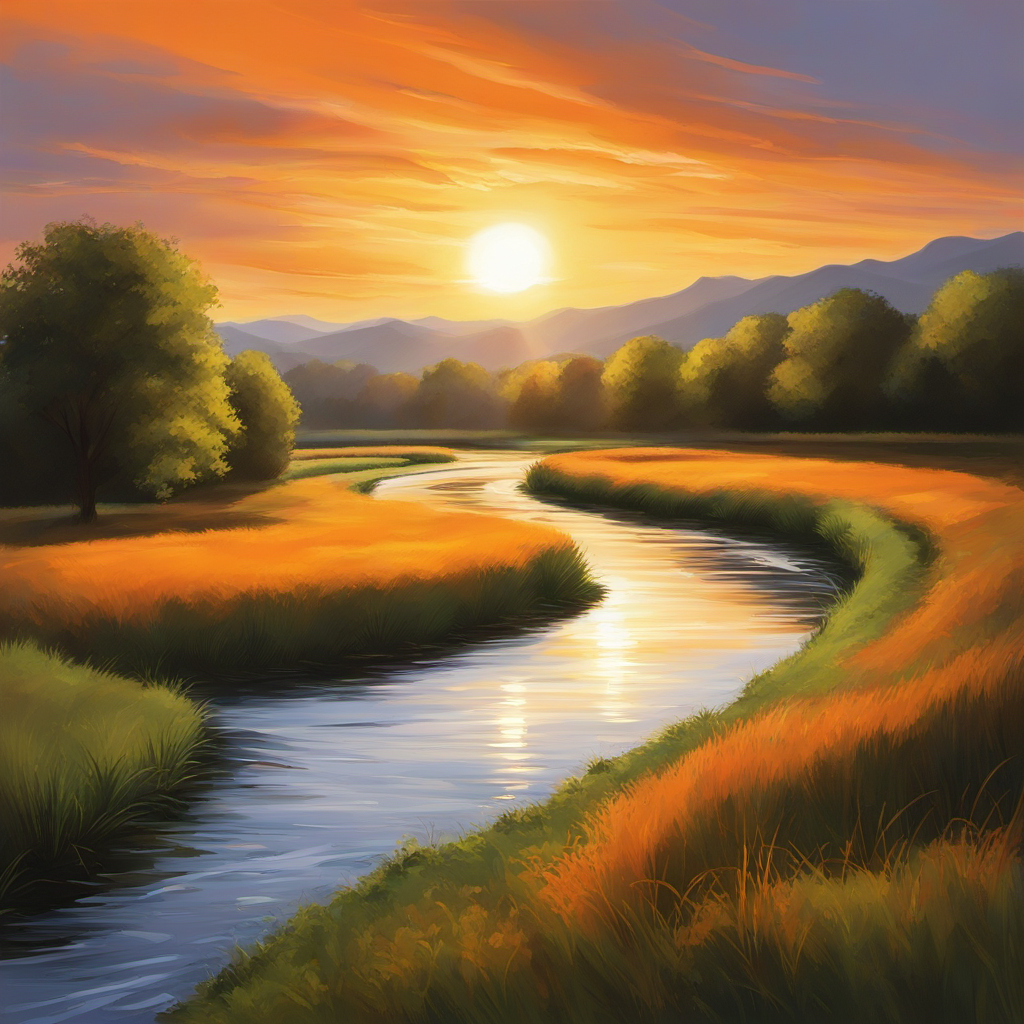

In [13]:
start_tag = "<stdout>"
end_tag = "</stdout>"

if start_tag in response and end_tag in response:
    start_index = response.find(start_tag) + len(start_tag)
    end_index = response.find(end_tag)
    stdout_content = response[start_index:end_index].strip()
    stdout_content = eval(stdout_content)
    for key, value in stdout_content.items():
        print("Image Prompt:", key)
        for image_url in value:
            image_name = image_url.split("filename=")[1].split("&")[0]
            # Send Http request and save image
            response = requests.get(image_url)
            if response.status_code == 200:
                save_path = os.path.join(images_folder, image_name)
                with open(save_path, "wb") as file:
                    file.write(response.content)
                    print(f"Image '{image_name}' saved to '{images_folder}'")
            else:
                print("Cannot download iamge")
            display(Image(filename=save_path))
else:
    print(response)

In [14]:
user_input = "The spaceship is soaring through a breathtaking landscape"
tools_string = add_tools()
prompt = create_prompt(tools_string, user_input)
response = run_loop(prompt)


You are an agent who can generate images using Stable Diffusion. Your job is to extract relevant image description from user input, then enrich and rewrite description into a prompt as much detail as possible to let Stable Diffusion understand. After that, you use one or more tools equipped for you to generate images based on the final prompt.

You may call the tools like this. Only invoke one function at a time and wait for the results before invoking another function:
<function_calls>
<invoke>
<tool_name>$TOOL_NAME</tool_name>
<parameters>
<$PARAMETER_NAME>$PARAMETER_VALUE</$PARAMETER_NAME>
...
</parameters>
</invoke>
</function_calls>

Here are the available equipped tools:
<tools>

<tool_description>
<tool_name>image_generator</tool_name>
<description>
Generate images for a given prompt and return prompt with images' URL. </description>
<parameters>
<parameter>
<name>final_prompt</name>
<type>string</type>
<description>The prompt for generating images</description>
</parameter> 
<

Image Prompt: Futuristic spaceship flying over alien terrain, rocky mountains in the distance, colorful nebulae in the sky, smooth metallic surfaces reflecting the landscape, flying at high speed through the atmosphere
Image 'ComfyUI_01181_.png' saved to './output_image'


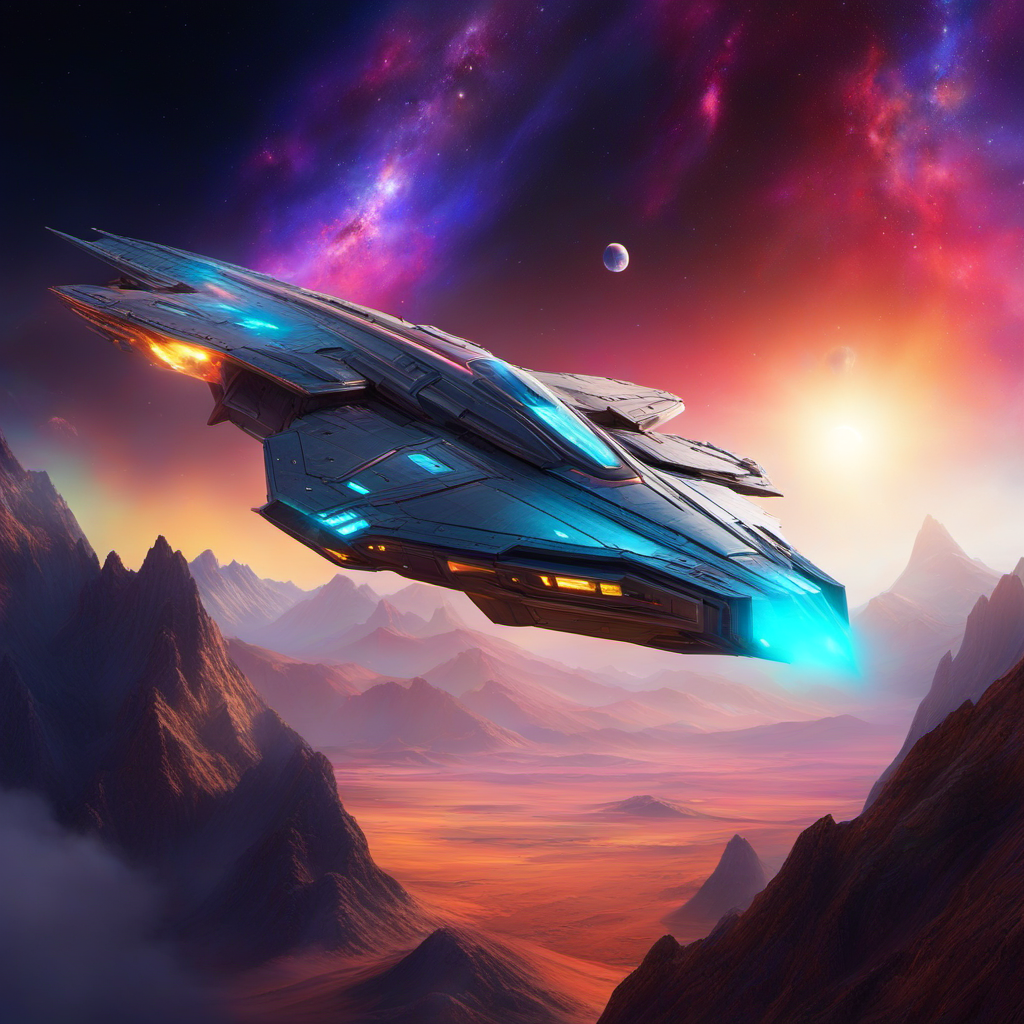

In [15]:
start_tag = "<stdout>"
end_tag = "</stdout>"

if start_tag in response and end_tag in response:
    start_index = response.find(start_tag) + len(start_tag)
    end_index = response.find(end_tag)
    stdout_content = response[start_index:end_index].strip()
    stdout_content = eval(stdout_content)
    for key, value in stdout_content.items():
        print("Image Prompt:", key)
        for image_url in value:
            image_name = image_url.split("filename=")[1].split("&")[0]
            # Send Http request and save image
            response = requests.get(image_url)
            if response.status_code == 200:
                save_path = os.path.join(images_folder, image_name)
                with open(save_path, "wb") as file:
                    file.write(response.content)
                    print(f"Image '{image_name}' saved to '{images_folder}'")
            else:
                print("Cannot download iamge")
            display(Image(filename=save_path))
else:
    print(response)